In [1]:
import gym
from gym import spaces

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import time
import random
import copy

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.distributions import Categorical

In [2]:
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.cuda.get_device_name(0))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

True
11.0
GeForce GTX 1660 Ti


In [3]:
# Gridworld Environment

class GridDeterministicEnvironment(gym.Env):
    metadata = { 'render.modes': [] }
    
    def __init__(self):
        self.observation_space = spaces.Discrete(8)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = 10
        
    def reset(self):
        self.timestep = 0
        self.agent_pos = [0, 0]
        self.goal_pos = [3, 1]
        self.state = np.zeros((4,2))
        self.state[tuple(self.agent_pos)] = 1
        
        observation = self.state.flatten()
        return observation
    
    def step(self, action):
        prev_pos = copy.deepcopy(self.agent_pos)
        if action == 0:
          self.agent_pos[0] += 1   # Down
        if action == 1:
          self.agent_pos[0] -= 1   # Up
        if action == 2:
          self.agent_pos[1] += 1   # Right
        if action == 3:
          self.agent_pos[1] -= 1   # Left
        
        self.agent_pos[0] = np.clip(self.agent_pos[0], 0, 3)
        self.agent_pos[1] = np.clip(self.agent_pos[1], 0, 1)
        self.state = np.zeros((4,2))
        self.state[tuple(self.agent_pos)] = 1
        
        observation = self.state.flatten()
        
        reward = 0
        if prev_pos != self.agent_pos:
            if self.agent_pos[0] > prev_pos[0] or self.agent_pos[1] > prev_pos[1]:
                reward = 1
            if self.agent_pos[0] < prev_pos[0] or self.agent_pos[1] < prev_pos[1]:
                reward = -1
                
        self.timestep += 1
        done = True if (self.timestep >= self.max_timesteps) or (self.agent_pos == self.goal_pos) else False
        
        return observation, reward, done, 0
        
    def render(self):
        plt.imshow(self.state)

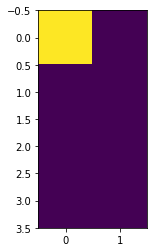

In [4]:
gwenv = GridDeterministicEnvironment()
obs = gwenv.reset()
gwenv.render()

In [5]:
class Actor(nn.Module):
    def __init__(self, no_states, no_actions, seed):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(no_states, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, no_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x),dim=-1)
        return x

In [6]:
class Critic(nn.Module):
    def __init__(self, no_states, seed):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(no_states, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
class A2C:
    def __init__(self, env, actor, critic, seed, num_eps, box):
        self.env = env
        env.seed(seed)
        if box == False:
            self.observation_space = self.env.observation_space.n
        else:
            self.observation_space = self.env.observation_space.shape[0]
        
        self.action_space = self.env.action_space.n
        self.actor_net = actor(self.observation_space, self.action_space, seed).to(device)
        self.critic_net = critic(self.observation_space, seed).to(device)
        self.seed = random.seed(seed)
        
        self.actor_optim = optim.Adam(self.actor_net.parameters(), lr = 1e-3)
        self.critic_optim = optim.Adam(self.critic_net.parameters(), lr = 1e-3)
        
        
        self.gamma = 0.99
        self.num_eps = num_eps
        self.eps_rew = []
        self.avg_rew = []
        
    def pick_action(self, state):
        probs = self.actor_net(state)
        dist = Categorical(probs=probs)
        action = dist.sample()
        return action, dist
        
    def train(self):
        for i in range(self.num_eps):
            if i%5 == 0:
                print(i,'episodes done')
            done = False
            tot_rew = 0
            state = self.env.reset()
            state = torch.tensor((state), dtype = torch.float, device = device)
            t = 0
            while not done:
                action, dist= self.pick_action(state)
                next_state, rew, done, info = self.env.step(action.detach().data.cpu().numpy())
                next_state = torch.tensor((next_state), dtype = torch.float, device = device)
                adv = rew + (1-done)*self.gamma*self.critic_net(next_state) - self.critic_net(state)
                tot_rew += rew
                state = next_state
                
                loss_c = adv.pow(2)[0]
                self.critic_optim.zero_grad()
                loss_c.backward()
                self.critic_optim.step()
                
                loss_a = -dist.log_prob(action)*adv.detach()
                self.actor_optim.zero_grad()
                loss_a.backward()
                self.actor_optim.step()
                t += 1
            
            self.eps_rew.append(tot_rew)     
            self.avg_rew.append(tot_rew/t)
        print('done')

In [8]:
class Critic(nn.Module):
    def __init__(self, no_states, seed):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(no_states, 32)
        self.fc2 = nn.Linear(32, 24)
        self.fc3 = nn.Linear(24, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
class Actor(nn.Module):
    def __init__(self, no_states, no_actions, seed):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(no_states, 24)
        self.fc2 = nn.Linear(24, 16)
        self.fc3 = nn.Linear(16, no_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x),dim=-1)
        return x

In [10]:
gwagent_1 = A2C(gwenv, Actor, Critic, 13, 75, 0)

In [11]:
gwagent_1.train()

0 episodes done
5 episodes done
10 episodes done
15 episodes done
20 episodes done
25 episodes done
30 episodes done
35 episodes done
40 episodes done
45 episodes done
50 episodes done
55 episodes done
60 episodes done
65 episodes done
70 episodes done
done


average rewards per episode: 3.3333333333333335


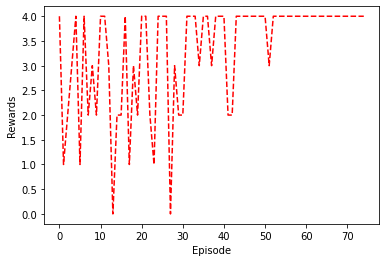

In [12]:
# Reward per Step
plt.figure()
plt.plot(gwagent_1.eps_rew, 'r--')
plt.ylabel('Rewards')
plt.xlabel('Episode')
print('average rewards per episode:', sum(gwagent_1.eps_rew)/75)

In [13]:
class Critic(nn.Module):
    def __init__(self, no_states, seed):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(no_states, 48)
        self.fc2 = nn.Linear(48, 24)
        self.fc3 = nn.Linear(24, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [14]:
class Actor(nn.Module):
    def __init__(self, no_states, no_actions, seed):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(no_states, 48)
        self.fc2 = nn.Linear(48, 24)
        self.fc3 = nn.Linear(24, no_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x),dim=-1)
        return x

In [15]:
gwagent_2 = A2C(gwenv, Actor, Critic, 314, 75, 0)

In [16]:
gwagent_2.train()

0 episodes done
5 episodes done
10 episodes done
15 episodes done
20 episodes done
25 episodes done
30 episodes done
35 episodes done
40 episodes done
45 episodes done
50 episodes done
55 episodes done
60 episodes done
65 episodes done
70 episodes done
done


average rewards per episode: 3.506666666666667


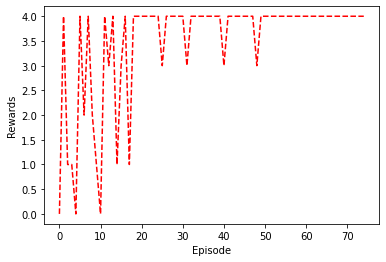

In [17]:
# Reward per Step
plt.figure()
plt.plot(gwagent_2.eps_rew, 'r--')
plt.ylabel('Rewards')
plt.xlabel('Episode')
print('average rewards per episode:', sum(gwagent_2.eps_rew)/75)

In [18]:
class Critic(nn.Module):
    def __init__(self, no_states, seed):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(no_states, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [19]:
class Actor(nn.Module):
    def __init__(self, no_states, no_actions, seed):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(no_states, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, no_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x),dim=-1)
        return x

In [20]:
gwagent_3 = A2C(gwenv, Actor, Critic, 135, 75, 0)

In [21]:
gwagent_3.train()

0 episodes done
5 episodes done
10 episodes done
15 episodes done
20 episodes done
25 episodes done
30 episodes done
35 episodes done
40 episodes done
45 episodes done
50 episodes done
55 episodes done
60 episodes done
65 episodes done
70 episodes done
done


average rewards per episode: 3.7066666666666666


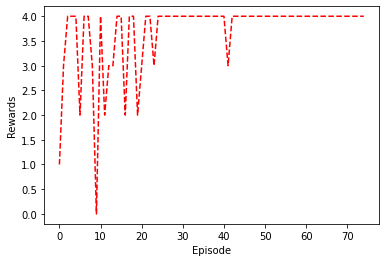

In [22]:
# Reward per Step
plt.figure()
plt.plot(gwagent_3.eps_rew, 'r--')
plt.ylabel('Rewards')
plt.xlabel('Episode')
print('average rewards per episode:', sum(gwagent_3.eps_rew)/75)

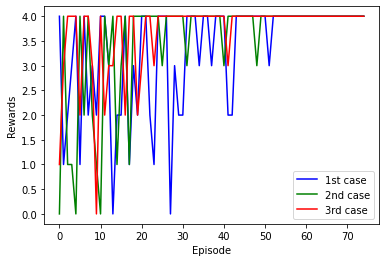

In [23]:
# Combined reward dynamics
plt.figure()
plt.plot(gwagent_1.eps_rew, 'b-', label = '1st case')
plt.plot(gwagent_2.eps_rew, 'g-', label = '2nd case')
plt.plot(gwagent_3.eps_rew, 'r-', label = '3rd case')
plt.ylabel('Rewards')
plt.xlabel('Episode')
legend = plt.legend()

In [24]:
cpenv = gym.make('CartPole-v1')

In [25]:
cpagent = A2C(cpenv, Actor, Critic, 123, 300, True)

In [26]:
cpagent.train()

0 episodes done
5 episodes done
10 episodes done
15 episodes done
20 episodes done
25 episodes done
30 episodes done
35 episodes done
40 episodes done
45 episodes done
50 episodes done
55 episodes done
60 episodes done
65 episodes done
70 episodes done
75 episodes done
80 episodes done
85 episodes done
90 episodes done
95 episodes done
100 episodes done
105 episodes done
110 episodes done
115 episodes done
120 episodes done
125 episodes done
130 episodes done
135 episodes done
140 episodes done
145 episodes done
150 episodes done
155 episodes done
160 episodes done
165 episodes done
170 episodes done
175 episodes done
180 episodes done
185 episodes done
190 episodes done
195 episodes done
200 episodes done
205 episodes done
210 episodes done
215 episodes done
220 episodes done
225 episodes done
230 episodes done
235 episodes done
240 episodes done
245 episodes done
250 episodes done
255 episodes done
260 episodes done
265 episodes done
270 episodes done
275 episodes done
280 episodes d

Text(0.5, 0, 'Episode')

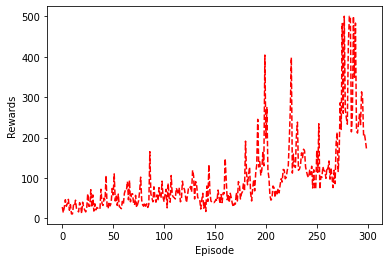

In [27]:
# Reward per episode
plt.figure()
plt.plot(cpagent.eps_rew, 'r--')
plt.ylabel('Rewards')
plt.xlabel('Episode')

Text(0.5, 0, 'Episode')

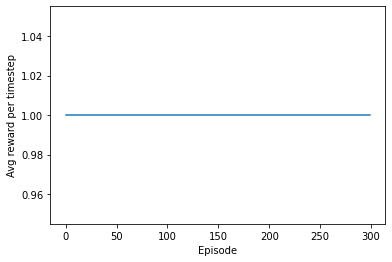

In [28]:
# Average reward per step
plt.figure()
plt.plot(cpagent.avg_rew)
plt.ylabel('Avg reward per timestep')
plt.xlabel('Episode')

In [29]:
llenv = gym.make('LunarLander-v2')

In [30]:
llagent = A2C(llenv, Actor, Critic, 123, 1000, True)

In [31]:
llagent.train()

0 episodes done
5 episodes done
10 episodes done
15 episodes done
20 episodes done
25 episodes done
30 episodes done
35 episodes done
40 episodes done
45 episodes done
50 episodes done
55 episodes done
60 episodes done
65 episodes done
70 episodes done
75 episodes done
80 episodes done
85 episodes done
90 episodes done
95 episodes done
100 episodes done
105 episodes done
110 episodes done
115 episodes done
120 episodes done
125 episodes done
130 episodes done
135 episodes done
140 episodes done
145 episodes done
150 episodes done
155 episodes done
160 episodes done
165 episodes done
170 episodes done
175 episodes done
180 episodes done
185 episodes done
190 episodes done
195 episodes done
200 episodes done
205 episodes done
210 episodes done
215 episodes done
220 episodes done
225 episodes done
230 episodes done
235 episodes done
240 episodes done
245 episodes done
250 episodes done
255 episodes done
260 episodes done
265 episodes done
270 episodes done
275 episodes done
280 episodes d

Text(0.5, 0, 'Episode')

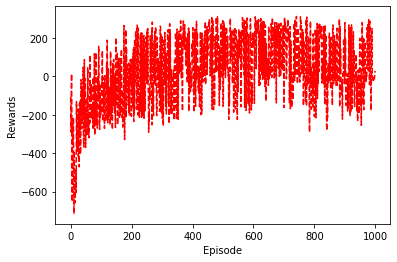

In [32]:
# Reward per Step
plt.figure()
plt.plot(llagent.eps_rew, 'r--')
plt.ylabel('Rewards')
plt.xlabel('Episode')

Text(0.5, 0, 'Episode')

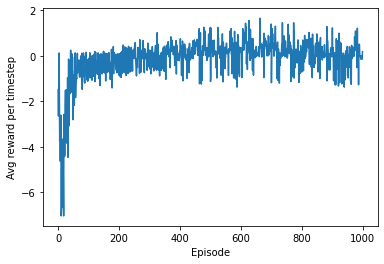

In [33]:
# Average reward per step
plt.figure()
plt.plot(llagent.avg_rew)
plt.ylabel('Avg reward per timestep')
plt.xlabel('Episode')